Loading /content/drive/MyDrive/Colab Notebooks/MHEALTH/mhealth_raw_data.csv...
Processing 130 segments...

=== New Metrics (AutoCorr & Entropy) Top 5 ===
    Subject   Activity  Acc_AutoCorr  Acc_SpecEntropy
0  subject1   Standing         0.056            0.940
1  subject1    Sitting         0.050            0.940
2  subject1      Lying         0.047            0.942
3  subject1    Walking         0.818            0.516
4  subject1  Stairs_Up         0.256            0.777


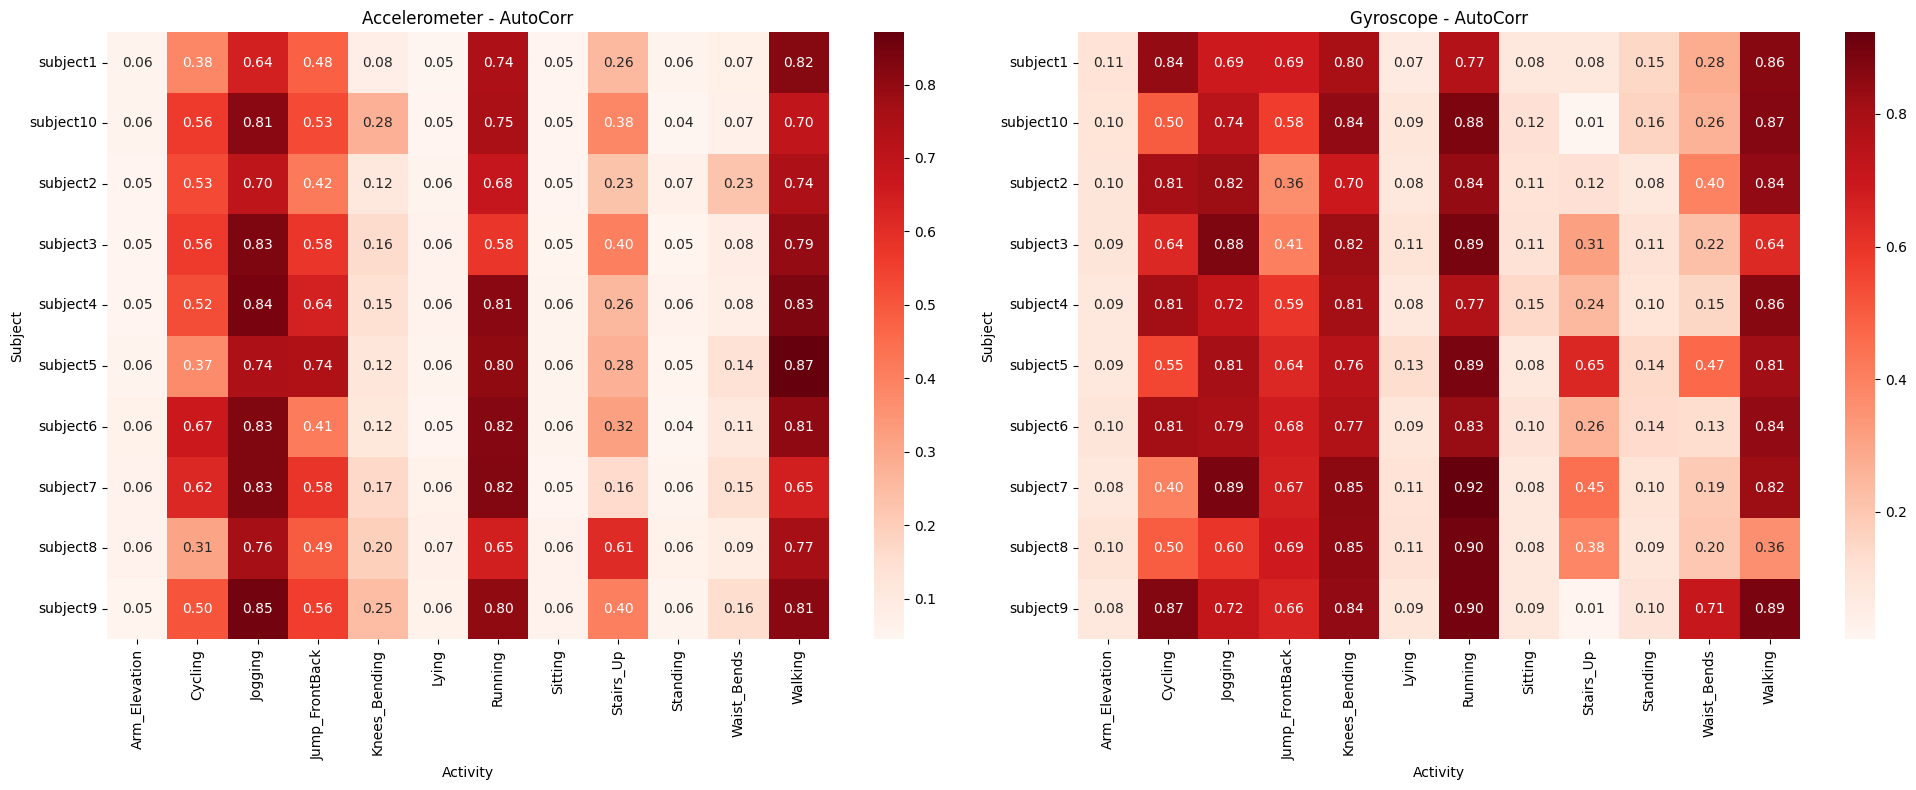

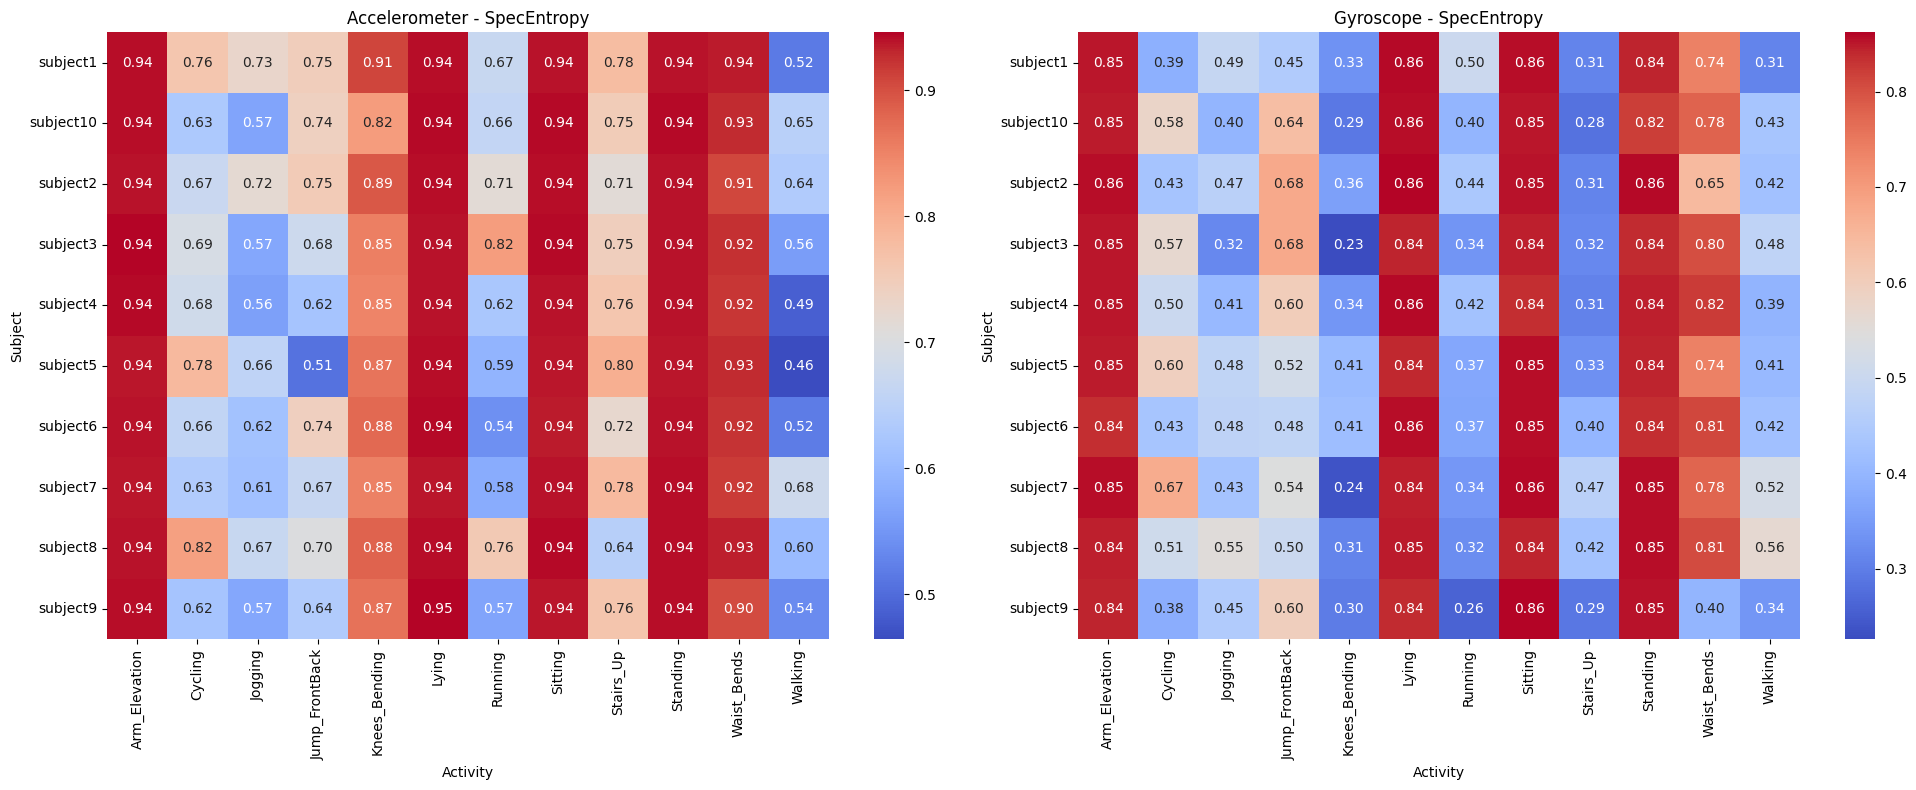

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, periodogram
from scipy.stats import kurtosis, entropy
import os

# ==========================================
# 1. 설정 및 상수
# ==========================================
FS = 50  # MHEALTH Dataset Sampling Rate

ACC_COLS = ['alx', 'aly', 'alz']
GYRO_COLS = ['glx', 'gly', 'glz']

ACTIVITY_MAP = {
    0: 'Null', 1: 'Standing', 2: 'Sitting', 3: 'Lying',
    4: 'Walking', 5: 'Stairs_Up', 6: 'Waist_Bends',
    7: 'Arm_Elevation', 8: 'Knees_Bending', 9: 'Cycling',
    10: 'Jogging', 11: 'Running', 12: 'Jump_FrontBack'
}

# ==========================================
# 2. 지표 계산 함수 (추가된 기능 포함)
# ==========================================

def get_autocorr_peak(signal_data):
    """
    자기상관성(Auto-correlation)의 최대 Peak값을 계산하여 주기성을 판단.
    1.0에 가까울수록 강한 주기성을 가짐.
    """
    # DC 성분(중력 등) 제거 후 계산해야 움직임 자체의 주기성 확인 가능
    centered = signal_data - np.mean(signal_data)

    # Full correlation 계산
    corr = np.correlate(centered, centered, mode='full')

    # 정규화 (Lag 0에서의 값이 1이 되도록)
    if np.max(corr) == 0:
        return 0.0
    corr_norm = corr / np.max(corr)

    # 절반(Positive Lag)만 사용
    half_len = len(corr_norm) // 2
    half_corr = corr_norm[half_len:]

    # Lag 0(인덱스 0)을 제외하고 첫 번째로 나타나는 유의미한 Peak 찾기
    peaks, properties = find_peaks(half_corr, height=0, distance=5)

    if len(peaks) > 0:
        # Lag 0을 제외한 가장 높은 Peak 반환 (주기성 강도)
        # 첫번째 peak가 Lag 0일 수 있으므로 인덱스 확인
        valid_peaks = [p for p in peaks if p > 0]
        if valid_peaks:
            # 해당 피크들의 높이 중 최댓값
            return np.max(half_corr[valid_peaks])

    return 0.0

def get_spectral_entropy(signal_data, fs):
    """
    주파수 도메인 엔트로피 (Spectral Entropy).
    낮을수록 단조로운 신호(Clean), 높을수록 무질서한 신호(Noisy/Complex).
    """
    # Power Spectral Density 계산
    f, Pxx = periodogram(signal_data, fs=fs)

    # 정규화 (확률 분포처럼 만듦)
    psd_norm = Pxx / np.sum(Pxx)

    # Shannon Entropy 계산 (scipy.stats.entropy 사용 시 base=e 기본, 여기선 bit 단위 비교 위해 base=2 추천하되 값 범위는 유사)
    # 완전한 White Noise면 log2(N), Pure Tone이면 0
    se = entropy(psd_norm, base=2)

    # 0~1 사이로 정규화 (선택 사항이나 비교를 위해 추천)
    se_normalized = se / np.log2(len(Pxx))
    return se_normalized

def calculate_sensor_metrics(data):
    """
    임의의 3축 센서 데이터(Acc 또는 Gyro)를 받아 지표를 계산
    """
    # 1. Magnitude (벡터 합) - 방향 무관한 에너지/주기성 분석용
    mag = np.linalg.norm(data, axis=1)

    # 2. Basic Metrics
    energy = np.mean(mag**2)
    std_val = np.std(mag)
    mean_val = np.mean(np.abs(mag)) + 1e-6
    snr = std_val / mean_val

    # 3. Transient Metrics
    kurt_val = kurtosis(mag, fisher=True)
    peak_val = np.max(np.abs(mag))
    rms_val = np.sqrt(np.mean(mag**2))
    crest_factor = peak_val / rms_val if rms_val != 0 else 0

    # 4. [NEW] Periodicity & Complexity
    autocorr = get_autocorr_peak(mag)
    spec_entropy = get_spectral_entropy(mag, fs=FS)

    return {
        'SNR': round(snr, 3),
        'Energy': round(energy, 2),
        'Kurtosis': round(kurt_val, 2),
        'Crest': round(crest_factor, 2),
        'AutoCorr': round(autocorr, 3),      # 주기성 (높을수록 좋음/규칙적)
        'SpecEntropy': round(spec_entropy, 3) # 복잡도 (낮을수록 좋음/명확함)
    }

# ==========================================
# 3. 통합 분석 함수
# ==========================================

def analyze_dual_sensors(file_path):
    print(f"Loading {file_path}...")
    df = pd.read_csv(file_path)

    missing_acc = [c for c in ACC_COLS if c not in df.columns]
    missing_gyro = [c for c in GYRO_COLS if c not in df.columns]

    if missing_acc: print(f"Warning: Acc columns missing {missing_acc}")
    if missing_gyro: print(f"Warning: Gyro columns missing {missing_gyro}")

    results = []

    # subject와 Activity로 그룹화
    grouped = df.groupby(['subject', 'Activity'])
    print(f"Processing {len(grouped)} segments...")

    for (subj, act_id), group in grouped:
        if act_id == 0: continue # Null 클래스 제외

        act_name = ACTIVITY_MAP.get(act_id, f'Unknown_{act_id}')

        row_data = {
            'Subject': subj,
            'Activity': act_name,
            'Data_Length': len(group)
        }

        # --- 가속도계 분석 ---
        if not missing_acc:
            acc_data = group[ACC_COLS].values
            acc_metrics = calculate_sensor_metrics(acc_data)
            for k, v in acc_metrics.items():
                row_data[f'Acc_{k}'] = v

        # --- 자이로스코프 분석 ---
        if not missing_gyro:
            gyro_data = group[GYRO_COLS].values
            gyro_metrics = calculate_sensor_metrics(gyro_data)
            for k, v in gyro_metrics.items():
                row_data[f'Gyro_{k}'] = v

        results.append(row_data)

    return pd.DataFrame(results)

# ==========================================
# 4. 다중 시각화 (SNR, AutoCorr, SpecEntropy)
# ==========================================

def plot_comparison_heatmap(df, metric='SNR'):
    """
    왼쪽: Acc Metric, 오른쪽: Gyro Metric 비교 히트맵
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # 색상 테마 설정: Entropy는 낮을수록 좋으므로 반전 colormap 고려 가능하지만
    # 여기서는 일관성을 위해 기본값 사용 (붉은색=높음, 초록색=낮음 등 데이터에 따라 해석)
    cmap = 'viridis'
    if metric == 'AutoCorr': cmap = 'Reds'     # 진할수록 주기성 강함
    if metric == 'SpecEntropy': cmap = 'coolwarm' # 붉을수록 무질서함

    # 가속도계
    pivot_acc = df.pivot(index='Subject', columns='Activity', values=f'Acc_{metric}')
    sns.heatmap(pivot_acc, cmap=cmap, annot=True, fmt=".2f", ax=axes[0])
    axes[0].set_title(f'Accelerometer - {metric}')

    # 자이로스코프
    pivot_gyro = df.pivot(index='Subject', columns='Activity', values=f'Gyro_{metric}')
    sns.heatmap(pivot_gyro, cmap=cmap, annot=True, fmt=".2f", ax=axes[1])
    axes[1].set_title(f'Gyroscope - {metric}')

    plt.tight_layout()
    plt.show()

# ==========================================
# 실행
# ==========================================
file_path = '/content/drive/MyDrive/Colab Notebooks/MHEALTH/mhealth_raw_data.csv'

if os.path.exists(file_path):
    df_result = analyze_dual_sensors(file_path)

    # 1. 결과 요약 출력
    cols_to_show = ['Subject', 'Activity', 'Acc_AutoCorr', 'Acc_SpecEntropy']
    print("\n=== New Metrics (AutoCorr & Entropy) Top 5 ===")
    print(df_result[cols_to_show].head())

    # 2. CSV 저장
    df_result.to_csv('mhealth_quality_metrics.csv', index=False)

    # 3. 시각화: 주기성 (규칙적인 운동인지?)
    plot_comparison_heatmap(df_result, metric='AutoCorr')

    # 4. 시각화: 신호 복잡도 (깔끔한 동작인지?)
    plot_comparison_heatmap(df_result, metric='SpecEntropy')

else:
    print("파일 경로를 확인해주세요.")

Loading /content/drive/MyDrive/Colab Notebooks/MHEALTH/mhealth_raw_data.csv...
Processing 130 segments...

=== SNR Comparison (Top 5 rows) ===
    Subject   Activity  Acc_SNR  Gyro_SNR
0  subject1   Standing    0.011     0.008
1  subject1    Sitting    0.011     0.007
2  subject1      Lying    0.011     0.010
3  subject1    Walking    0.400     0.041
4  subject1  Stairs_Up    0.301     0.465

=== Kurtosis Comparison (Top 5 rows) ===
    Subject   Activity  Acc_Kurtosis  Gyro_Kurtosis
0  subject1   Standing          0.63           0.20
1  subject1    Sitting          0.30          -0.14
2  subject1      Lying          0.22          -0.10
3  subject1    Walking          0.30          -0.81
4  subject1  Stairs_Up          4.91           2.33


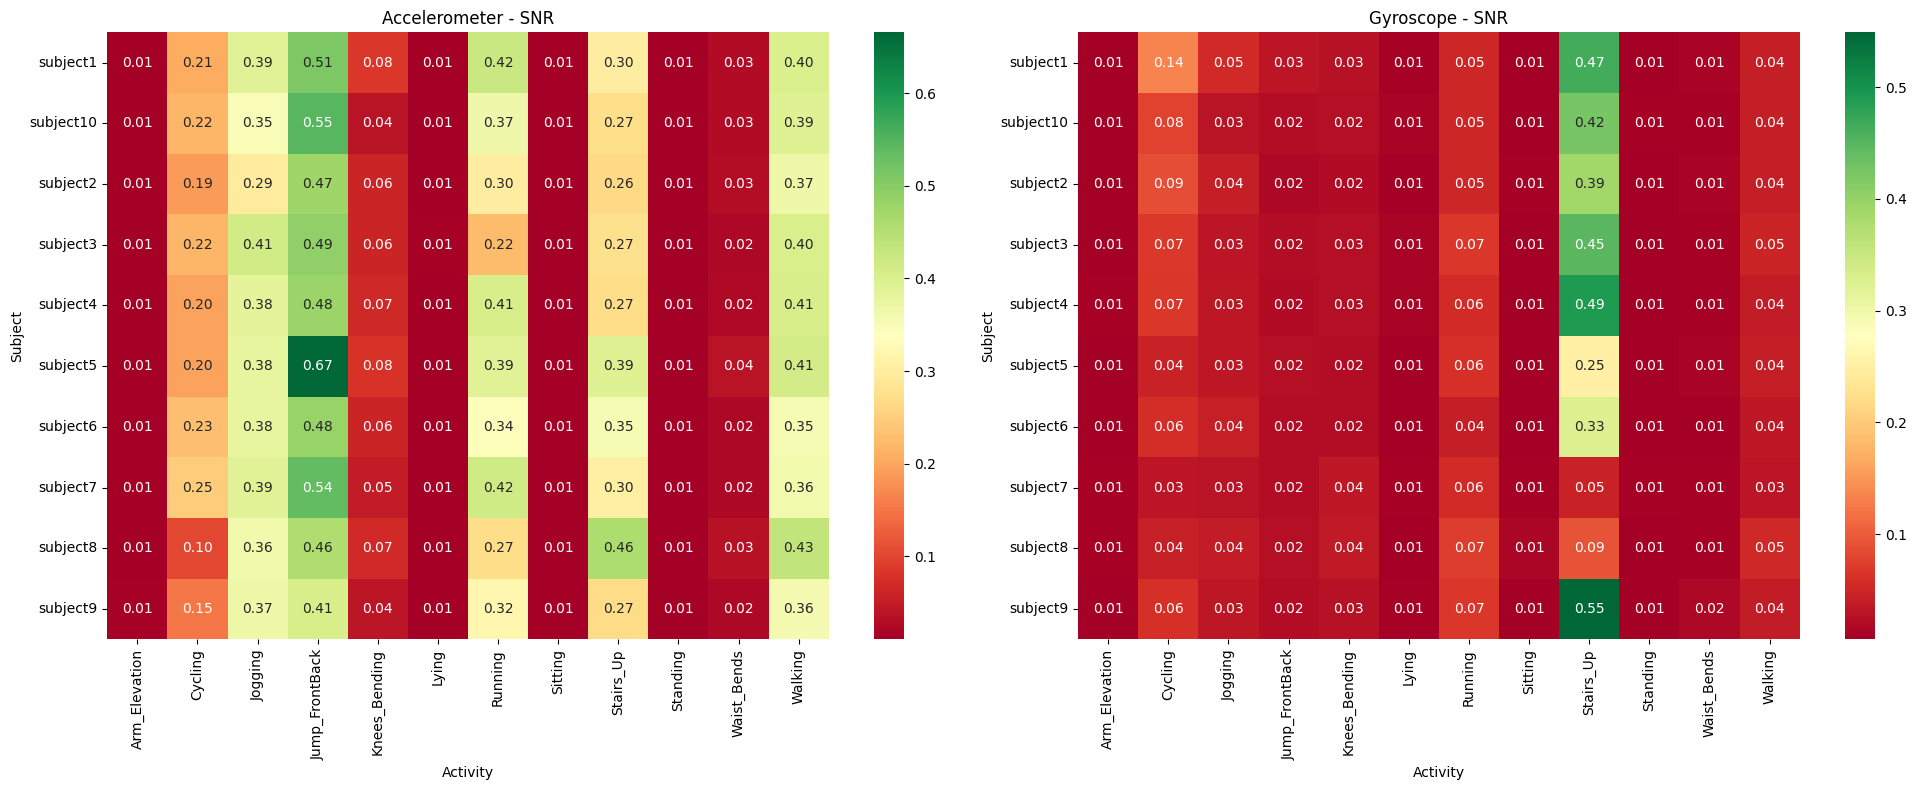

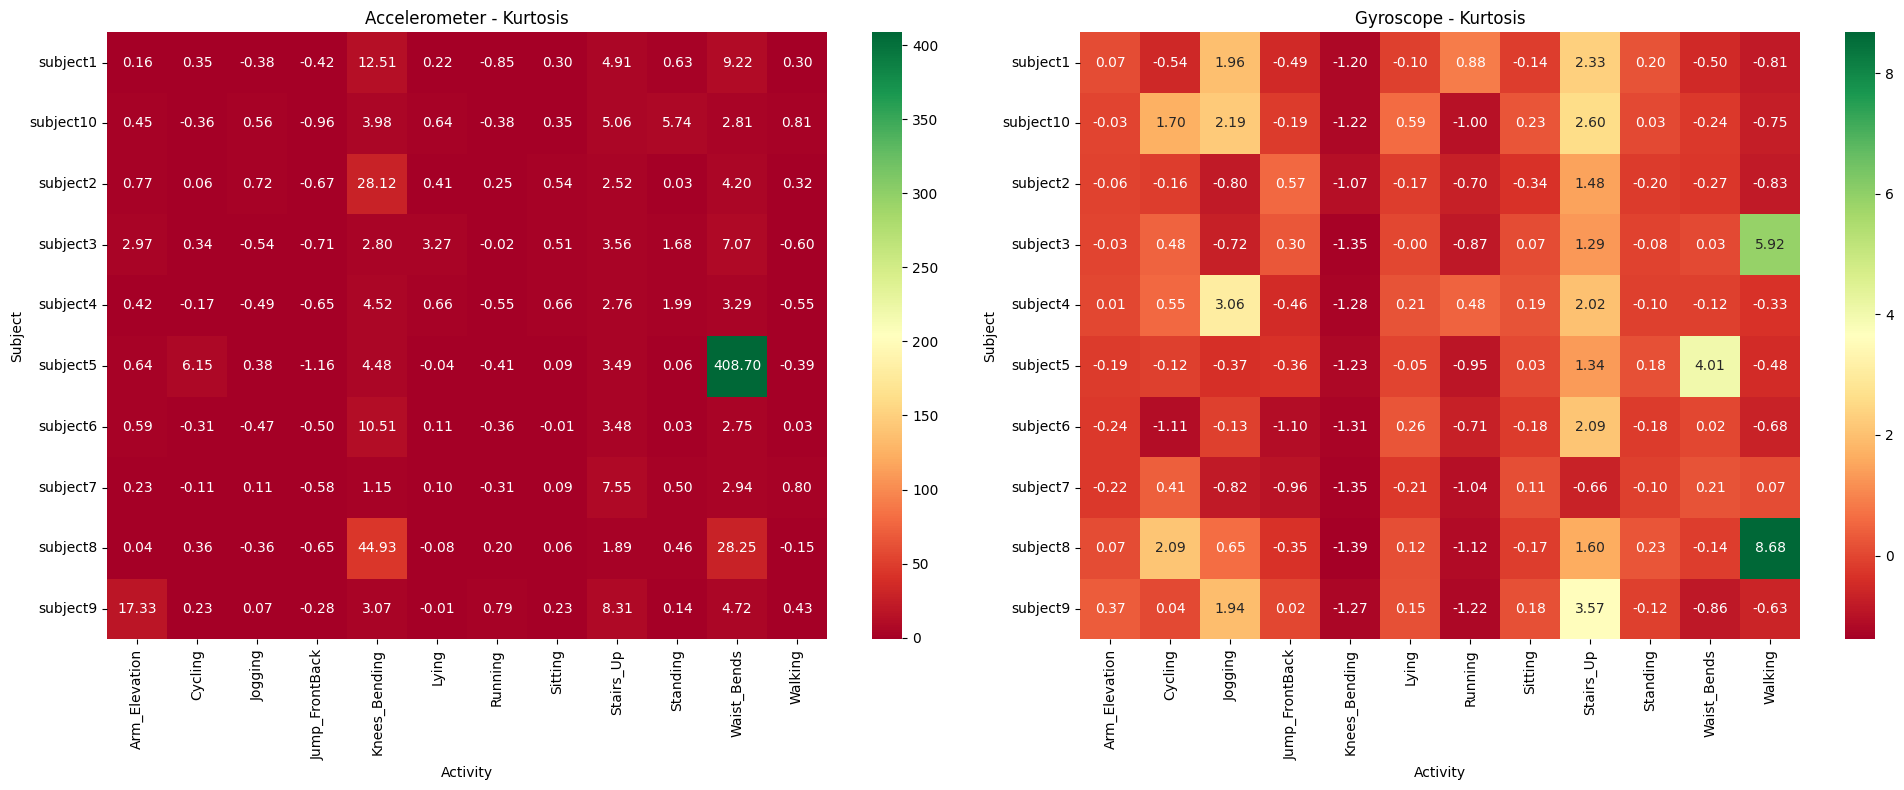

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.stats import kurtosis
import os

# ==========================================
# 1. 컬럼 설정 (데이터 파일 헤더 확인 필요)
# ==========================================
# MHEALTH 데이터셋의 일반적인 컬럼명 가정
ACC_COLS = ['alx', 'aly', 'alz']
GYRO_COLS = ['glx', 'gly', 'glz']

ACTIVITY_MAP = {
    0: 'Null', 1: 'Standing', 2: 'Sitting', 3: 'Lying',
    4: 'Walking', 5: 'Stairs_Up', 6: 'Waist_Bends',
    7: 'Arm_Elevation', 8: 'Knees_Bending', 9: 'Cycling',
    10: 'Jogging', 11: 'Running', 12: 'Jump_FrontBack'
}

# ==========================================
# 2. 공통 계산 함수 (센서 무관)
# ==========================================

def calculate_sensor_metrics(data):
    """
    임의의 3축 센서 데이터(Acc 또는 Gyro)를 받아 지표를 계산
    """
    # 1. Magnitude (벡터 합)
    mag = np.linalg.norm(data, axis=1)

    # 2. Basic Metrics (SNR, Energy)
    energy = np.mean(mag**2)
    std_val = np.std(mag)
    mean_val = np.mean(np.abs(mag)) + 1e-6
    snr = std_val / mean_val

    # 3. Transient Metrics (Kurtosis, Crest Factor)
    kurt_val = kurtosis(mag, fisher=True)

    peak_val = np.max(np.abs(mag))
    rms_val = np.sqrt(np.mean(mag**2))
    crest_factor = peak_val / rms_val if rms_val != 0 else 0

    return {
        'SNR': round(snr, 3),
        'Energy': round(energy, 2),
        'Kurtosis': round(kurt_val, 2),
        'Crest': round(crest_factor, 2)
    }

# ==========================================
# 3. 통합 분석 (Acc vs Gyro)
# ==========================================

def analyze_dual_sensors(file_path):
    print(f"Loading {file_path}...")
    df = pd.read_csv(file_path)

    # 컬럼 존재 여부 확인
    missing_acc = [c for c in ACC_COLS if c not in df.columns]
    missing_gyro = [c for c in GYRO_COLS if c not in df.columns]

    if missing_acc: print(f"Warning: Acc columns missing {missing_acc}")
    if missing_gyro: print(f"Warning: Gyro columns missing {missing_gyro}")

    results = []

    grouped = df.groupby(['subject', 'Activity'])
    print(f"Processing {len(grouped)} segments...")

    for (subj, act_id), group in grouped:
        if act_id == 0: continue

        act_name = ACTIVITY_MAP.get(act_id, f'Unknown_{act_id}')

        row_data = {
            'Subject': subj,
            'Activity': act_name,
            'Data_Length': len(group)
        }

        # --- 가속도계 분석 ---
        if not missing_acc:
            acc_data = group[ACC_COLS].values
            acc_metrics = calculate_sensor_metrics(acc_data)
            # 결과 딕셔너리에 'Acc_' 접두어로 저장
            for k, v in acc_metrics.items():
                row_data[f'Acc_{k}'] = v

        # --- 자이로스코프 분석 ---
        if not missing_gyro:
            gyro_data = group[GYRO_COLS].values
            gyro_metrics = calculate_sensor_metrics(gyro_data)
            # 결과 딕셔너리에 'Gyro_' 접두어로 저장
            for k, v in gyro_metrics.items():
                row_data[f'Gyro_{k}'] = v

        results.append(row_data)

    return pd.DataFrame(results)

# ==========================================
# 4. 비교 시각화 (Heatmap Side-by-Side)
# ==========================================

def plot_comparison_heatmap(df, metric='SNR'):
    """
    왼쪽: Acc Metric, 오른쪽: Gyro Metric 비교 히트맵
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # 가속도계
    pivot_acc = df.pivot(index='Subject', columns='Activity', values=f'Acc_{metric}')
    sns.heatmap(pivot_acc, cmap='RdYlGn', annot=True, fmt=".2f", ax=axes[0])
    axes[0].set_title(f'Accelerometer - {metric}')

    # 자이로스코프
    pivot_gyro = df.pivot(index='Subject', columns='Activity', values=f'Gyro_{metric}')
    sns.heatmap(pivot_gyro, cmap='RdYlGn', annot=True, fmt=".2f", ax=axes[1])
    axes[1].set_title(f'Gyroscope - {metric}')

    plt.tight_layout()
    plt.show()

# ==========================================
# 실행
# ==========================================
file_path = '/content/drive/MyDrive/Colab Notebooks/MHEALTH/mhealth_raw_data.csv'

if os.path.exists(file_path):
    df_result = analyze_dual_sensors(file_path)

    pd.set_option('display.max_columns', None)

    # 1. SNR 비교 (가속도 vs 자이로)
    print("\n=== SNR Comparison (Top 5 rows) ===")
    print(df_result[['Subject', 'Activity', 'Acc_SNR', 'Gyro_SNR']].head())

    # 2. 첨도(Kurtosis) 비교 - 이벤트 감지 능력 차이 확인
    print("\n=== Kurtosis Comparison (Top 5 rows) ===")
    print(df_result[['Subject', 'Activity', 'Acc_Kurtosis', 'Gyro_Kurtosis']].head())

    # 3. CSV 저장
    df_result.to_csv('mhealth_dual_sensor_report.csv', index=False)

    # 4. 시각화: SNR 비교
    plot_comparison_heatmap(df_result, metric='SNR')

    # 5. 시각화: Kurtosis 비교 (전이 구간 선명도 차이)
    # Kurtosis는 높을수록(붉을수록) 날카로운 신호
    plot_comparison_heatmap(df_result, metric='Kurtosis')

else:
    print("파일 없음")